# Methoden en Technieken -- Blok 2

## Datapunt Opdracht

In deze opdracht worden de volgende leeruitkomsten getoetst, relevante termen zijn **dik** gedrukt:
- B2: Je stelt op basis van requirements een **geschikte architectuur** voor een AI-oplossing op en selecteert daarvoor passende AI-technieken, gebruik makend van **machine learning**, **deep learning**, **kennisrepresentatie**, **computer vision** en natural language processing.
- B3: Je prepareert een dataset voor het **trainen en testen** van een AI-model rekening houdend met technische en ethische randvoorwaarden.
- B4: **Je ontwikkelt, traint en evalueert een AI-model** volgens een **iteratief proces**.
- C2: **Je evalueert en beoordeelt de kwaliteit van een AI-model aan de hand van kwaliteitscriteria** die in het vakgebied erkend worden waaronder robustness, **performance**, scalability, explainability, model complexity en resource demand.

## De opdracht

In de slides van les 12 word beschreven hoe we een Deep Belief Netwerk unsupervised trainen op de MNIST data. 

In deze opdracht gaan we dit gebruiken om een MNIST classifier semi-supervised te trainen. We doen hier alsof slechts 500 van de 70000 MNIST afbeeldingen gelabeld zijn (zie code hieronder, deze maakt de data aan die je mag gebruiken). Je zult dus:
- Een DBN unsupervised trainen op de data
- Een classifier trainen op de latent space van de DBN en de gelabelde data

Je mag zelf kiezen:
- De architectuur van de DBN (let op, deze zal wat tijd kosten om te trainen)
- De classifier op de latent space (alles is toegestaan)
- Hoe je de modellen beoordeelt

Probeer een zo'n goed mogelijk model te krijgen (in een redelijke tijd), verantwoord je keuzes. Bespreek je uiteindelijke model in detail, eerdere pogingen/modellen mogen korter besproken worden.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import BernoulliRBM
from ipywidgets import interactive
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch.nn.functional as F


In [2]:
(x1, y), (x2, _) = keras.datasets.mnist.load_data()
x = np.concatenate((x1, x2))

x = np.expand_dims(x, -1).astype("float32") / 255

y = y[:500]

del x1, x2

In [3]:
# Select the first 500 labels as labeled data
labeled_x = x[:500]
labeled_y = y[:500]

# The rest are unlabeled data
unlabeled_x = x[500:]

Split it by catagory and not random. (stratisfied split)

In [4]:
X_labeled_train, x_labeled_remaining, y_labeled_train,  y_labeled_remaining = train_test_split(labeled_x, labeled_y, test_size=0.3, random_state = 42)
X_labeled_validation, X_labeled_test,y_labeled_validation,  y_test = train_test_split(x_labeled_remaining, y_labeled_remaining, test_size=0.5, random_state = 42)
y_labeled_train = keras.utils.to_categorical(y_labeled_train, 10)
y_labeled_validation = keras.utils.to_categorical(y_labeled_validation, 10)
y_labeled_test = keras.utils.to_categorical(y_test, 10)

In [5]:
print(X_labeled_train.shape)

(350, 28, 28, 1)


In [6]:
unlabeled_x = unlabeled_x.reshape(len(unlabeled_x), -1)
X_labeled_train = X_labeled_train.reshape(len(X_labeled_train), -1)
X_labeled_validation = X_labeled_validation.reshape(len(X_labeled_validation), -1)
X_labeled_test = X_labeled_test.reshape(len(X_labeled_test), -1)

In [7]:
print(X_labeled_train.shape)

(350, 784)


Add null model

Do minimum size model: something like: random, 10

In [8]:
hidden_sizes = [364, 91, 45, 10]

In [15]:
inp = unlabeled_x
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 100, random_state = 42, verbose=1)    
    # rbm = BernoulliRBM(size, learning_rate = 0.2, batch_size = 500, n_iter = 1, random_state = 42, verbose=1)
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

[BernoulliRBM] Iteration 1, pseudo-likelihood = -200.78, time = 2.28s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -200.09, time = 2.39s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -199.90, time = 2.42s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -199.90, time = 2.35s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -199.89, time = 2.41s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -199.88, time = 2.42s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -199.77, time = 2.36s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -199.74, time = 2.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -199.81, time = 2.40s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -199.74, time = 2.40s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -199.79, time = 2.41s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -199.77, time = 2.41s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -199.87, time = 2.41s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -199.79, time = 2.37s
[BernoulliRBM] 

In [9]:
def sample(rbms, rng, ngibbs=20):

    # Perform Gibbs sampling with the last RBM
    v = rng.binomial(1, 0.2, size=hidden_sizes[-2])
    for i in range(ngibbs):
        v = rbms[-1].gibbs(v)

    # Perform ancestral sampling for the other layers
    for i in range(len(rbms)-2, -1, -1):
        v = rbms[i]._sample_visibles(v, rng)
    
    return v

RBM inner representatation of the number.

In [15]:
def makeplot(seed):
    rng = np.random.RandomState(seed)

    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(sample(RBMs, rng).reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()

interactive(makeplot, seed=(0,10))
        

interactive(children=(IntSlider(value=5, description='seed', max=10), Output()), _dom_classes=('widget-interac…

How good the model is at recognising the numbers.

In [14]:
def makeplot2(n, seed):
    rng = np.random.RandomState(seed)
    img = X_labeled_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(makeplot2, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

Evaluate on the epochs.

Evaluate on the evaluation metrics (probably just lookit at the images ;).

In [39]:
with open('DBN_2B.pickle', 'wb') as file:
    pickle.dump(RBMs, file)

In [13]:
with open('DBN_2B.pickle', 'rb') as file:
    RBMs = pickle.load(file)

Add minimum size layers: 1, 10

Uitleggen waarom welke activatie functie gebruikt bij elke layer.

In [ ]:
# Define a PyTorch model
class RBMPyTorchModel(nn.Module):
    def __init__(self):
        super(RBMPyTorchModel, self).__init__()
        self.rbm1 = nn.Linear(784, 364, bias=True)
        self.rbm2 = nn.Linear(364, 91, bias=True)
        self.rbm3 = nn.Linear(91, 45, bias=True)
        self.rbm4 = nn.Linear(45, 10, bias=True)
        
        self.fc1 = nn.Linear(10, 10)

    def forward(self, x):
        x = torch.sigmoid(self.rbm1(x))
        x = torch.sigmoid(self.rbm2(x))
        x = torch.sigmoid(self.rbm3(x))
        x = torch.sigmoid(self.rbm4(x))
        x = torch.relu(self.fc1(x))
        return x

# Create a PyTorch model
model = RBMPyTorchModel()

# Transfer parameters to PyTorch model
with torch.no_grad():
    model.rbm1.weight.copy_(torch.tensor(RBMs[0].components_.T.T))
    model.rbm1.bias.copy_(torch.tensor(RBMs[0].intercept_hidden_))
    
    model.rbm2.weight.copy_(torch.tensor(RBMs[1].components_.T.T))
    model.rbm2.bias.copy_(torch.tensor(RBMs[1].intercept_hidden_))
    
    model.rbm3.weight.copy_(torch.tensor(RBMs[2].components_.T.T))
    model.rbm3.bias.copy_(torch.tensor(RBMs[2].intercept_hidden_))
    
    model.rbm4.weight.copy_(torch.tensor(RBMs[3].components_.T.T))
    model.rbm4.bias.copy_(torch.tensor(RBMs[3].intercept_hidden_))

# Freeze the first 3 layers
for param in model.rbm1.parameters():
    param.requires_grad = False
for param in model.rbm2.parameters():
    param.requires_grad = False
for param in model.rbm3.parameters():
    param.requires_grad = False
for param in model.rbm4.parameters():
    param.requires_grad = False
    
print(model)

RBMPyTorchModel(
  (rbm1): Linear(in_features=784, out_features=364, bias=True)
  (rbm2): Linear(in_features=364, out_features=91, bias=True)
  (rbm3): Linear(in_features=91, out_features=45, bias=True)
  (rbm4): Linear(in_features=45, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train = torch.tensor(X_labeled_train, dtype=torch.float32)
y_train = torch.tensor(y_labeled_train, dtype=torch.float32)

X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)
y_val = torch.tensor(y_labeled_validation, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

print("Training complete!")

Epoch [1/100], Loss: 2.3789, Val Loss: 2.2305
Epoch [2/100], Loss: 2.2132, Val Loss: 2.1346
Epoch [3/100], Loss: 2.1307, Val Loss: 2.0297
Epoch [4/100], Loss: 2.0479, Val Loss: 1.9158
Epoch [5/100], Loss: 1.9924, Val Loss: 1.7918
Epoch [6/100], Loss: 1.8989, Val Loss: 1.6636
Epoch [7/100], Loss: 1.7627, Val Loss: 1.5236
Epoch [8/100], Loss: 1.6663, Val Loss: 1.3848
Epoch [9/100], Loss: 1.6212, Val Loss: 1.2710
Epoch [10/100], Loss: 1.5525, Val Loss: 1.1756
Epoch [11/100], Loss: 1.6206, Val Loss: 1.1011
Epoch [12/100], Loss: 1.5335, Val Loss: 1.0269
Epoch [13/100], Loss: 1.4597, Val Loss: 0.9629
Epoch [14/100], Loss: 1.5045, Val Loss: 0.9155
Epoch [15/100], Loss: 1.4444, Val Loss: 0.8714
Epoch [16/100], Loss: 1.5869, Val Loss: 0.8444
Epoch [17/100], Loss: 1.5264, Val Loss: 0.8116
Epoch [18/100], Loss: 1.6041, Val Loss: 0.7806
Epoch [19/100], Loss: 1.5815, Val Loss: 0.7581
Epoch [20/100], Loss: 1.3267, Val Loss: 0.7245
Epoch [21/100], Loss: 1.4438, Val Loss: 0.7078
Epoch [22/100], Loss: 

In [46]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model saved!")

Model saved!


In [23]:
# Load the model
model = RBMPyTorchModel()  # Replace with your model class
model.load_state_dict(torch.load('model.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded!")

Model loaded!


C:\Users\jelma\AppData\Local\Temp\ipykernel_6444\3057561021.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Evaluate on the epochs.

Explain why the optimizer.

Evaluate on learning rate.

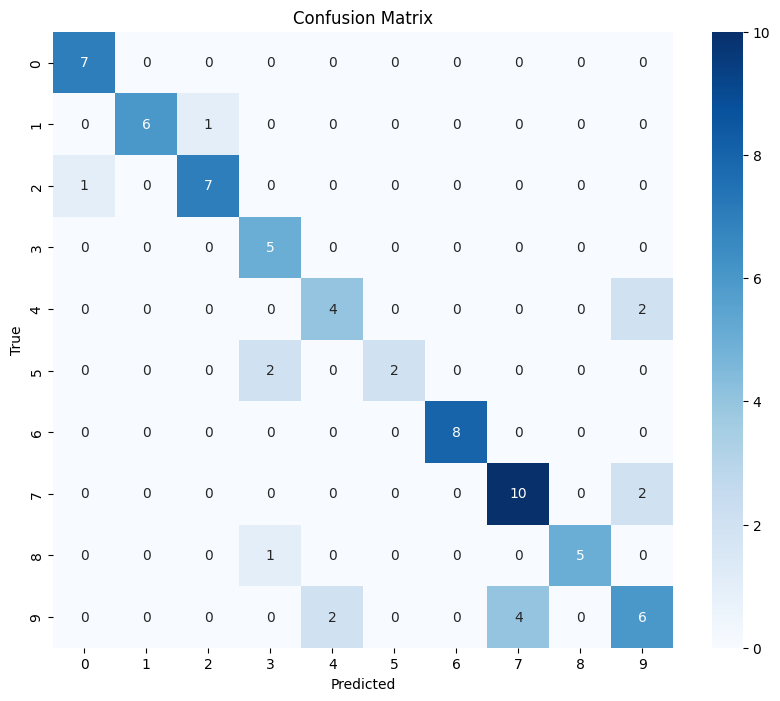

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7
           2       0.88      0.88      0.88         8
           3       0.62      1.00      0.77         5
           4       0.67      0.67      0.67         6
           5       1.00      0.50      0.67         4
           6       1.00      1.00      1.00         8
           7       0.71      0.83      0.77        12
           8       1.00      0.83      0.91         6
           9       0.60      0.50      0.55        12

    accuracy                           0.80        75
   macro avg       0.84      0.81      0.81        75
weighted avg       0.81      0.80      0.80        75



In [18]:
# Ensure model is in evaluation mode
model.eval()

# Convert validation data to PyTorch tensor
X_val = torch.tensor(X_labeled_validation, dtype=torch.float32)

# Get raw logits from the model
y_pred_logits = model(X_val)

# Apply softmax to convert logits to probabilities
y_pred_probs = F.softmax(y_pred_logits, dim=1)

# Get the predicted classes (index of the max probability)
y_pred_classes = torch.argmax(y_pred_probs, dim=1).numpy()

# Get ground truth labels (convert to class indices if needed)
y_true = y_labeled_validation
if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes))


Evaluate on the metrics.

Compare final result to the null model.

Evaluate final model on the metrics (cross entropy or something).

Manualy grade the results of the image classification.